In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [13]:
# convert to geo dataframe
start_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df['start_lon'], df['start_lat']), crs = 'epsg:4326')

# update projection 
start_gpd.to_crs(epsg=2263, inplace = True)

In [14]:
gpd_sub = start_gpd.drop_duplicates(['start_id'])
gpd_sub.shape

(958, 20)

In [3]:
# supply and demand

starts_hrly = df.groupby(['hour','start_id'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','start_id','start_count']
starts_hrly

,hour,start_id,start_count
0,0,72,45
1,0,79,11
2,0,82,4
3,0,83,35
4,0,116,32
...,...,...,...
22045,23,4020,45
22046,23,4023,26
22047,23,4036,19
22048,23,4037,5


In [4]:
ends_hrly = df.groupby(['hour','end_id'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','end_id','end_count']
ends_hrly

,hour,end_id,end_count
0,0,72,53
1,0,79,8
2,0,82,10
3,0,83,17
4,0,116,40
...,...,...,...
22065,23,4021,1
22066,23,4023,40
22067,23,4036,11
22068,23,4037,8


In [5]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','start_id'],
                               right_on = ['hour','end_id'],
                               how = 'outer')
supply_hrly.head(10)

,hour,start_id,start_count,end_id,end_count
0,0,72.0,45.0,72.0,53.0
1,0,79.0,11.0,79.0,8.0
2,0,82.0,4.0,82.0,10.0
3,0,83.0,35.0,83.0,17.0
4,0,116.0,32.0,116.0,40.0
5,0,119.0,23.0,119.0,21.0
6,0,120.0,14.0,120.0,7.0
7,0,127.0,39.0,127.0,20.0
8,0,128.0,72.0,128.0,62.0
9,0,143.0,19.0,143.0,19.0


In [6]:
supply_hrly['start_count'].fillna(0, inplace=True)
supply_hrly['end_count'].fillna(0, inplace=True)

In [7]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 28

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/28
supply_hrly.sort_values(by = 'hrly_surplus')

,hour,start_id,start_count,end_id,end_count,hrly_surplus
14774,16,3141.0,1278.0,3141.0,524.0,-26.928571
15731,17,3141.0,1328.0,3141.0,653.0,-24.107143
13819,15,3141.0,919.0,3141.0,491.0,-15.285714
15126,16,3687.0,686.0,3687.0,320.0,-13.071429
14687,16,2012.0,529.0,2012.0,172.0,-12.750000
...,...,...,...,...,...,...
6193,7,3141.0,928.0,3141.0,1349.0,15.035714
5282,6,3156.0,118.0,3156.0,622.0,18.000000
5616,6,3687.0,143.0,3687.0,762.0,22.107143
5184,6,2012.0,113.0,2012.0,764.0,23.250000


In [8]:
supply_hrly.sort_values(by = 'hrly_surplus', ascending = False).head(10)

,hour,start_id,start_count,end_id,end_count,hrly_surplus
5270,6,3141.0,240.0,3141.0,1341.0,39.321429
5184,6,2012.0,113.0,2012.0,764.0,23.250000
5616,6,3687.0,143.0,3687.0,762.0,22.107143
5282,6,3156.0,118.0,3156.0,622.0,18.000000
6193,7,3141.0,928.0,3141.0,1349.0,15.035714
5379,6,3345.0,56.0,3345.0,466.0,14.642857
6545,7,3687.0,371.0,3687.0,748.0,13.464286
7139,8,3141.0,738.0,3141.0,1089.0,12.535714
8089,9,3141.0,412.0,3141.0,736.0,11.571429
7052,8,2012.0,222.0,2012.0,532.0,11.071429


In [9]:
supply_3141 = supply_hrly[supply_hrly['start_id'] == 3141]
supply_2012 = supply_hrly[supply_hrly['start_id'] == 2012]
supply_3687 = supply_hrly[supply_hrly['start_id'] == 3687]
supply_3156 = supply_hrly[supply_hrly['start_id'] == 3156]
supply_3345 = supply_hrly[supply_hrly['start_id'] == 3345]

In [10]:
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')

[]

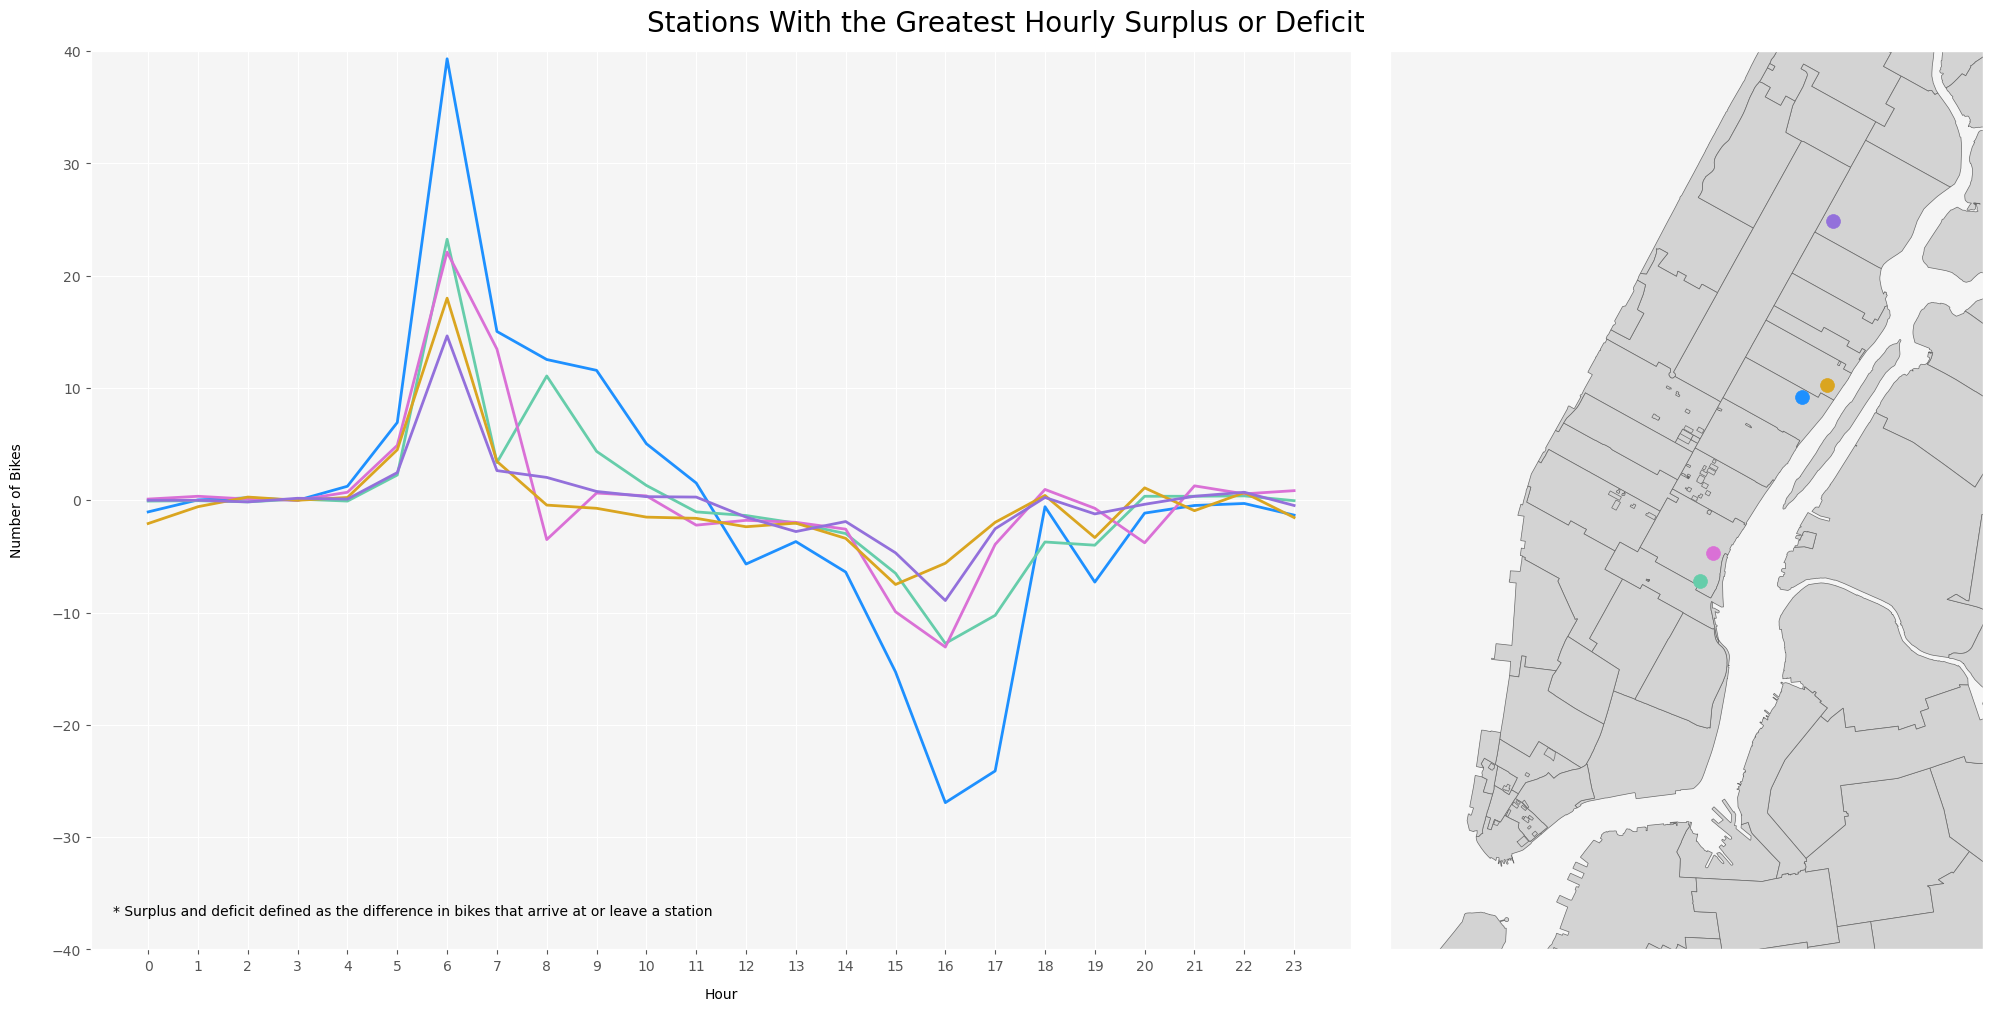

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,  
                        figsize=(20, 10), width_ratios = [2, 1],
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)

fig.suptitle('Stations With the Greatest Hourly Surplus or Deficit', fontsize=20)

x = np.arange(24)
supply_3141.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'dodgerblue', linewidth = 2)
supply_2012.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'mediumaquamarine', linewidth = 2)
supply_3687.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'orchid', linewidth = 2)
supply_3156.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'goldenrod', linewidth = 2)
supply_3345.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'mediumpurple', linewidth = 2)

ax1.set_xticks(x)
ax1.set_xlabel('Hour', labelpad = 10)
ax1.set_ylabel('Number of Bikes', labelpad = 20)
ax1.set_ylim(-40, 40)
ax1.set_facecolor("whitesmoke")
ax1.legend('', frameon = False)
ax1.text(-0.7, -37, '* Surplus and deficit defined as the difference in bikes that arrive at or leave a station')


zip_shp.plot(ax=ax2, color='lightgrey', edgecolor = 'dimgray')
gpd_sub[gpd_sub['start_id'] == 3141].plot(ax=ax2, markersize= 100, color = 'dodgerblue')
gpd_sub[gpd_sub['start_id'] == 2012].plot(ax=ax2, markersize= 100, color = 'mediumaquamarine')
gpd_sub[gpd_sub['start_id'] == 3687].plot(ax=ax2, markersize= 100, color = 'orchid')
gpd_sub[gpd_sub['start_id'] == 3156].plot(ax=ax2, markersize= 100, color = 'goldenrod')
gpd_sub[gpd_sub['start_id'] == 3345].plot(ax=ax2, markersize= 100, color = 'mediumpurple')

ax2.set_xlim(975000, 1005000)
ax2.set_ylim(190000, 235500)

ax2.set_facecolor("whitesmoke")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])